<a href="https://colab.research.google.com/github/Abecid/deepest-quest/blob/main/colab/NLP_Quest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# NLP Quest

## Summary
    # 1. Trasformer
    # 2. Data Normalization
    # 3. MLP (Classification)

In [2]:
import pandas as pd

# Data
train_data_path = '/Users/adamlee/Downloads/Deepest/deepest-quest/2023-Spring/NLP/data/utkmls-twitter-spam-detection-competition/train.csv'
test_data_path = '/Users/adamlee/Downloads/Deepest/deepest-quest/2023-Spring/NLP/data/utkmls-twitter-spam-detection-competition/test.csv'

train_data_path = 'https://raw.githubusercontent.com/Abecid/deepest-quest/main/2023-Spring/NLP/data/utkmls-twitter-spam-detection-competition/train.csv'
test_data_path = 'https://raw.githubusercontent.com/Abecid/deepest-quest/main/2023-Spring/NLP/data/utkmls-twitter-spam-detection-competition/test.csv'

# train_data = pd.read_csv(train_data_path).drop(columns=['following', 'followers', 'actions', 'is_retweet', 'location'])
# test_data = pd.read_csv(test_data_path).drop(columns=['following', 'followers', 'actions', 'is_retweet', 'location'])

train_data = pd.read_csv(train_data_path)[["Tweet", "Type"]]
test_data = pd.read_csv(test_data_path)[["Tweet"]]

# 0: Quality, 1: Spam
train_data['Type'] = train_data['Type'].map({'Quality': 0, 'Spam': 1})

train_data

,Tweet,Type
0,Good Morning Love @LeeBrown_V,0.0
1,'@realDonaldTrump @USNavy RIP TO HEROES',1.0
2,Haven't been following the news but I understa...,0.0
3,pic.twitter.com/dy9q4ftLhZ What to do with pap...,0.0
4,#DidYouKnow ► Mahatma Gandhi made a brief visi...,0.0
...,...,...
14894,"#AllWentWrongWhen I told my hair stylist to ""g...",1.0
14895,"They don't have to like you, and you don't hav...",0.0
14896,#Miami Graham Nash Live at Parker Playhouse #...,1.0
14897,@bethannhamilton is in the business of one-upp...,0.0


In [3]:
test_data


,Tweet
0,"Cops shoot blacks almost everyday, and there a..."
1,"#HAPPYTAEYANGDAY Oppa,happy birthday to you, ..."
2,RT @HoneyBadger10: Panthers in the super bowl....
3,Sorry my Twitter keeps posting my retweets a m...
4,Heart attack causes and symptoms are different...
...,...
780,New Project For NLex Please @DreamscapePH @abs...
781,Actor DiCaprio joins growing movement to dives...
782,Just overheard 'looping in' 'reaching out' and...
783,Photoshoot time! #music #band #photoshootpic.t...


<Axes: xlabel='Type', ylabel='count'>

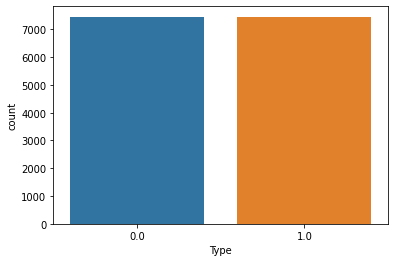

In [4]:
import seaborn as sns
sns.countplot(x = train_data["Type"], data = train_data)

In [3]:
from torchtext.models import XLMR_BASE_ENCODER
from sklearn.model_selection import train_test_split
import copy

# Split the data into training and testing sets with a 70/30 split
train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=42)

train_df

,Tweet,Type
1891,Guys! Check out my playlist and new single #DU...,0.0
2996,#StopPoliceViolence #StopPoliceBrutality #Stop...,1.0
7341,Biology exam went better than I expected,0.0
12802,We are proud to be part of this study!https://...,0.0
4043,IBM's optical storage is 50 times faster than ...,0.0
...,...,...
5191,The amended #aqabiology specificationpic.twitt...,0.0
13418,We fail in people management when we do only I...,0.0
5390,#TrumpSlide coming to restore America! I can't...,1.0
860,'@johncardillo @realDonaldTrump https://t.co/I...,1.0


In [6]:
# https://www.auroria.io/nlp-disaster-tweet-text-classification-roberta-pytorch/

from torch.utils.data import Dataset
import numpy as np
import re
import nltk
import string

class TweetDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        texts = dataframe.Tweet.values.tolist()

        texts = [self._preprocess(text) for text in texts]

        self._print_random_samples(texts)

        self.texts = [tokenizer(text, padding='max_length',
                                max_length=150,
                                truncation=True,
                                return_tensors="pt")
                      for text in texts]

        if 'Type' in dataframe:
            classes = dataframe.Type.values.tolist()
            self.labels = classes

    def _print_random_samples(self, texts):
        np.random.seed(42)
        random_entries = np.random.randint(0, len(texts), 5)

        for i in random_entries:
            print(f"Entry {i}: {texts[i]}")

        print()

    def _preprocess(self, text):
        text = self._remove_amp(text)
        text = self._remove_links(text)
        text = self._remove_hashes(text)
        text = self._remove_retweets(text)
        text = self._remove_mentions(text)
        text = self._remove_multiple_spaces(text)

        #text = self._lowercase(text)
        text = self._remove_punctuation(text)
        # text = self._remove_numbers(text)

        text_tokens = self._tokenize(text)
        text_tokens = self._stopword_filtering(text_tokens)
        # text_tokens = self._stemming(text_tokens)
        text = self._stitch_text_tokens_together(text_tokens)

        return text.strip()


    def _remove_amp(self, text):
        return text.replace("&amp;", " ")

    def _remove_mentions(self, text):
        return re.sub(r'(@.*?)[\s]', ' ', text)
    
    def _remove_multiple_spaces(self, text):
        return re.sub(r'\s+', ' ', text)

    def _remove_retweets(self, text):
        return re.sub(r'^RT[\s]+', ' ', text)

    def _remove_links(self, text):
        return re.sub(r'https?:\/\/[^\s\n\r]+', ' ', text)

    def _remove_hashes(self, text):
        return re.sub(r'#', ' ', text)

    def _stitch_text_tokens_together(self, text_tokens):
        return " ".join(text_tokens)

    def _tokenize(self, text):
        return nltk.word_tokenize(text, language="english")

    def _stopword_filtering(self, text_tokens):
        stop_words = nltk.corpus.stopwords.words('english')

        return [token for token in text_tokens if token not in stop_words]

    def _stemming(self, text_tokens):
        porter = nltk.stem.porter.PorterStemmer()
        return [porter.stem(token) for token in text_tokens]

    def _remove_numbers(self, text):
        return re.sub(r'\d+', ' ', text)

    def _lowercase(self, text):
        return text.lower()

    def _remove_punctuation(self, text):
        return ''.join(character for character in text if character not in string.punctuation)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]

        label = -1
        if hasattr(self, 'labels'):
            label = self.labels[idx]

        return text, label

In [7]:
# Model
from torch import nn

class TweetClassifier(nn.Module):
    def __init__(self, base_model):
        super(TweetClassifier, self).__init__()

        self.bert = base_model
        self.fc1 = nn.Linear(768, 32)
        self.fc2 = nn.Linear(32, 1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input_ids, attention_mask):
        bert_out = self.bert(input_ids=input_ids,
                             attention_mask=attention_mask)[0][:, 0]
        x = self.fc1(bert_out)
        x = self.relu(x)
        
        x = self.fc2(x)
        x = self.sigmoid(x)

        return x

In [8]:
import torch
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_dataloader, val_dataloader, learning_rate, epochs):
    best_val_loss = float('inf')
    early_stopping_threshold_count = 5
    
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    model = model.to(device)
    criterion = criterion.to(device)

    for epoch in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        
        model.train()
        
        for train_input, train_label in tqdm(train_dataloader):
            attention_mask = train_input['attention_mask'].to(device)
            input_ids = train_input['input_ids'].squeeze(1).to(device)

            train_label = train_label.to(device)

            output = model(input_ids, attention_mask)

            loss = criterion(output, train_label.float().unsqueeze(1))

            total_loss_train += loss.item()

            acc = ((output >= 0.5).int() == train_label.unsqueeze(1)).sum().item()
            total_acc_train += acc

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        with torch.no_grad():
            total_acc_val = 0
            total_loss_val = 0
            
            model.eval()
            
            for val_input, val_label in tqdm(val_dataloader):
                attention_mask = val_input['attention_mask'].to(device)
                input_ids = val_input['input_ids'].squeeze(1).to(device)

                val_label = val_label.to(device)

                output = model(input_ids, attention_mask)

                loss = criterion(output, val_label.float().unsqueeze(1))

                total_loss_val += loss.item()

                acc = ((output >= 0.5).int() == val_label.unsqueeze(1)).sum().item()
                total_acc_val += acc
            
            print(f'Epochs: {epoch + 1} '
                  f'| Train Loss: {total_loss_train / len(train_dataloader): .3f} '
                  f'| Train Accuracy: {total_acc_train / (len(train_dataloader.dataset)): .3f} '
                  f'| Val Loss: {total_loss_val / len(val_dataloader): .3f} '
                  f'| Val Accuracy: {total_acc_val / len(val_dataloader.dataset): .3f}')
            
            if best_val_loss > total_loss_val:
                best_val_loss = total_loss_val
                torch.save(model, f"best_model.pt")
                print("Saved model")
                early_stopping_threshold_count = 0
            else:
                early_stopping_threshold_count += 1
                
            if early_stopping_threshold_count >= 1:
                print("Early stopping")
                break

In [9]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.tokenize import sent_tokenize

text = "This is a sentence. This is another sentence."
sentences = sent_tokenize(text)
print(sentences)

['This is a sentence.', 'This is another sentence.']


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
!nvidia-smi

Fri Mar 24 08:50:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P0    42W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
import numpy as np

from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader

torch.manual_seed(0)
np.random.seed(0)

batch_size = 8
    
BERT_MODEL = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)
base_model = AutoModel.from_pretrained(BERT_MODEL)

train_dataloader = DataLoader(TweetDataset(train_df, tokenizer), batch_size=batch_size, shuffle=True, num_workers=12)
val_dataloader = DataLoader(TweetDataset(val_df, tokenizer), batch_size=batch_size, num_workers=12)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Entry 7270: Yeah striped socks
Entry 860: alis BOOM Trump ERASES Another Piece Obamas Failed Legacy lis
Entry 5390: Lee Amendment Can Stop AFFH puts Washington bureaucrats charge local government
Entry 5191: Now Playing Metro Boomin ft Drake Offset No Complaints gt
Entry 11284: andris Satellite Imagery Suggests North Korea Preparing Submarine Missile Test

Entry 860: miss …
Entry 1294: Start record label via RT201
Entry 1130: mom told u wake like 29283 times youre still laying suddenly comes roompictwittercomzVgcRm6dca
Entry 1095: For talk much sucks easily handled Bernie sanders shes done trump 16 GOP candidates couldnt
Entry 1638: Thinking getting new tires summer We lot different rebates going right Stop expire



In [12]:
for train_input, train_label in (train_dataloader):
    print("x:", train_input, "y:", train_label)
    break

x: {'input_ids': tensor([[[    0, 29734,   101,  ...,     1,     1,     1]],

        [[    0,  3750,   513,  ...,     1,     1,     1]],

        [[    0, 21136,   188,  ...,     1,     1,     1]],

        ...,

        [[    0, 34002,  6645,  ...,     1,     1,     1]],

        [[    0, 41597,   459,  ...,     1,     1,     1]],

        [[    0, 14323, 17967,  ...,     1,     1,     1]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        ...,

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]]])} y: tensor([0., 0., 1., 0., 0., 0., 1., 1.], dtype=torch.float64)


In [14]:
model = TweetClassifier(base_model)


learning_rate = 1e-5
epochs = 50
train(model, train_dataloader, val_dataloader, learning_rate, epochs)

  0%|          | 0/1490 [00:00<?, ?it/s]


RuntimeError: ignored

In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# https://pytorch.org/text/main/tutorials/sst2_classification_non_distributed.html

import torch

num_classes = 2
input_dim = 768

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchtext.models import RobertaClassificationHead, XLMR_BASE_ENCODER

classifier_head = RobertaClassificationHead(num_classes=num_classes, input_dim=input_dim)
model = XLMR_BASE_ENCODER.get_model(head=classifier_head)
model.to(device)

RobertaModel(
  (encoder): RobertaEncoder(
    (transformer): TransformerEncoder(
      (token_embedding): Embedding(250002, 768, padding_idx=1)
      (layers): TransformerEncoder(
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (linear1): Linear(in_features=768, out_features=3072, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=3072, out_features=768, bias=True)
            (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
          (1): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj)

In [9]:
import torchtext.functional as F
from torch.optim import AdamW
import torch.nn as nn

learning_rate = 1e-5
optim = AdamW(model.parameters(), lr=learning_rate)
criteria = nn.CrossEntropyLoss()

padding_idx = 1


def train_step(input, target):
    output = model(input)
    loss = criteria(output, target)
    optim.zero_grad()
    loss.backward()
    optim.step()


def eval_step(input, target):
    output = model(input)
    loss = criteria(output, target).item()
    return float(loss), (output.argmax(1) == target).type(torch.float).sum().item()


def evaluate():
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    counter = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input = F.to_tensor(batch["token_ids"], padding_value=padding_idx).to(DEVICE)
            target = torch.tensor(batch["target"]).to(DEVICE)
            loss, predictions = eval_step(input, target)
            total_loss += loss
            correct_predictions += predictions
            total_predictions += len(target)
            counter += 1

    return total_loss / counter, correct_predictions / total_predictions

In [12]:
num_epochs = 1

for e in range(num_epochs):
    for input, target in train_dataloader:
        input = input['input_ids'].squeeze(1).to(device)
        # input = F.to_tensor(batch["token_ids"], padding_value=padding_idx).to(device)
        target = torch.tensor(target).to(device)
        train_step(input, target)

    loss, accuracy = evaluate()
    print("Epoch = [{}], loss = [{}], accuracy = [{}]".format(e, loss, accuracy))

<ipython-input-12-5e8bd958a308>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target).to(device)


RuntimeError: ignored

In [ ]:
import torch
import torch.nn as nn

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

class TwitterSpamDetector(nn.Module):
    def __init__(self, num_tokens, emb_size, num_heads, hidden_size, num_layers, dropout_prob, num_following, num_followers, num_actions):
        super().__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(num_tokens, emb_size)
        
        # Transformer encoder
        self.encoder_layer = nn.TransformerEncoderLayer(emb_size, num_heads, hidden_size, dropout_prob)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers)
        
        # MLP layers
        self.mlp = nn.Sequential(
            nn.Linear(emb_size + num_following + num_followers + num_actions + 1, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

        self.num_following = num_following
        self.num_followers = num_followers
        self.num_actions = num_actions
        
    def forward(self, x, following, followers, actions, is_retweet):
        # Encode input sequence with Transformer
        x = self.embedding(x)
        x = self.transformer_encoder(x)

        # Concatenate normalized input values
        following_norm = following.float()
        followers_norm = followers.float()
        actions_norm = actions.float()
        is_retweet = is_retweet.float()
        input_vec = torch.cat([x.mean(dim=1), following_norm.unsqueeze(1), followers_norm.unsqueeze(1), actions_norm.unsqueeze(1), is_retweet.unsqueeze(1)], dim=1)

        # Pass through MLP layers
        y = self.mlp(input_vec)

        return y
